<a href="https://colab.research.google.com/github/zilioalberto/N1---MachineLearning/blob/main/N1_Machine_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##N1 - Machiine Learning - Comite classificador
##Alunos:
##Alberto Zilio
##Lucas Carvalho Esteffens
##Roni Pereira

##Data Set Escolhido:
##Previsão de Fluxo de Tráfego
#https://archive.ics.uci.edu/dataset/608/traffic+flow+forecasting


In [1]:
#Download do dataset

# URL raw do arquivo no seu repo
RAW_URL = "https://raw.githubusercontent.com/zilioalberto/N1---MachineLearning/main/traffic_dataset.mat"

# Download do arquivo para o ambiente do Colab
!curl -L -o traffic_dataset.mat "$RAW_URL"

# Conferir se baixou
!ls -lh traffic_dataset.mat


# Verificando o formato: "MATLAB 5.0 MAT-file" (v7 até v7.2) ou "\x89HDF" (v7.3/HDF5)
with open("traffic_dataset.mat", "rb") as f:
    head = f.read(16)
print(head)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4298k  100 4298k    0     0  8377k      0 --:--:-- --:--:-- --:--:-- 8379k
-rw-r--r-- 1 root root 4.2M Sep 17 00:18 traffic_dataset.mat
b'MATLAB 5.0 MAT-f'


In [32]:
#Importar as bibliotecas:

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.sparse as sp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt




In [13]:
#Carregar o dataset

data = sio.loadmat("traffic_dataset.mat")

# Extrai as variáveis principais
tra_X_tr = data["tra_X_tr"]
tra_Y_tr = data["tra_Y_tr"]
tra_X_te = data["tra_X_te"]
tra_Y_te = data["tra_Y_te"]
tra_adj  = data.get("tra_adj_mat", None)


In [14]:
#Normalizar os dados

#Transformar tra_X_tr / tra_X_te em formato (T, S, F)

#T = número de instantes no tempo

#S = número de sensores (36)

#F = número de features (48)

# --- utilitário: esparso -> denso (ou mantém como está) ---

def to_dense(a):
    """Converte csc/csr/coo para ndarray denso; mantém ndarray como está."""
    return a.toarray() if sp.issparse(a) else np.array(a)


def X_to_TSF(X):
    """Converte array (1,T) de cells (S,F) em ndarray (T,S,F)."""
    T = X.shape[1]
    sample0 = to_dense(X[0,0])
    S, F = sample0.shape
    out = np.empty((T, S, F), dtype=float)
    for t in range(T):
        out[t] = to_dense(X[0,t])
    return out

def Y_to_ST(Y):
    """Garante formato (S,T)"""
    Yd = to_dense(Y)
    if Yd.shape[0] == 36:
        return Yd
    if Yd.shape[1] == 36:
        return Yd.T
    raise ValueError(f"Formato inesperado para Y: {Yd.shape}")

# Normalizar
Xtr = X_to_TSF(tra_X_tr)
Ytr = Y_to_ST(tra_Y_tr)
Xte = X_to_TSF(tra_X_te)
Yte = Y_to_ST(tra_Y_te)

print("Xtr:", Xtr.shape, "| Ytr:", Ytr.shape)
print("Xte:", Xte.shape, "| Yte:", Yte.shape)


Xtr: (1261, 36, 48) | Ytr: (36, 1261)
Xte: (840, 36, 48) | Yte: (36, 840)


In [15]:
#Empilhar em formato tabular (samples × features)

#Cada linha = um sensor em um instante de tempo.
#Assim temos o dataset pronto para ML:

def stack_TS(X_ts, Y_st):
    T, S, F = X_ts.shape
    X = X_ts.reshape(T*S, F)
    y = Y_st.T.reshape(T*S)
    return X, y

X_tr, y_tr = stack_TS(Xtr, Ytr)
X_te, y_te = stack_TS(Xte, Yte)

print("Treino:", X_tr.shape, y_tr.shape)
print("Teste:", X_te.shape, y_te.shape)


Treino: (45396, 48) (45396,)
Teste: (30240, 48) (30240,)


In [16]:
#Unificar em um único dataset, já que originalmente está dividido em 60% de aprendizado e 40% de teste
X_all = np.vstack([X_tr, X_te])
y_all = np.hstack([y_tr, y_te])

print("Dataset unificado:", X_all.shape, y_all.shape)

Dataset unificado: (75636, 48) (75636,)


In [17]:
# === AMOSTRA DO DATASET UNIFICADO (tabular) ===

# 1) Empilhar treino e teste
def stack_TS(X_ts, Y_st):
    T, S, F = X_ts.shape
    X = X_ts.reshape(T*S, F)
    y = Y_st.T.reshape(T*S)
    return X, y

X_tr, y_tr = stack_TS(Xtr, Ytr)
X_te, y_te = stack_TS(Xte, Yte)

X_all = np.vstack([X_tr, X_te])     # (75636, 48)
y_all = np.hstack([y_tr, y_te])     # (75636,)

# 2) Reconstruir índice de sensor e tempo para o dataset empilhado
SENSORS = 36
def idx_to_sensor_time(idx, sensors=SENSORS):
    t = idx // sensors  # índice temporal
    s = idx % sensors   # id do sensor
    return s, t

idxs = np.arange(X_all.shape[0])
sensor_ids = idxs % SENSORS
t_indices   = idxs // SENSORS

# 3) Montar DataFrame com nomes de colunas
feat_cols = [f"f{i:02d}" for i in range(X_all.shape[1])]
df_all = pd.DataFrame(X_all, columns=feat_cols)
df_all["target_reg"] = y_all
df_all["sensor_id"]  = sensor_ids
df_all["t_index"]    = t_indices

# 4) Criar classes por tercis no alvo contínuo
#    Observação: isso é só para INSPEÇÃO. Para treinar/avaliar, gere os cortes a partir do CONJUNTO DE TREINO.
q1, q2 = np.quantile(y_all, [1/3, 2/3])
df_all["target_cls"] = np.where(df_all["target_reg"] <= q1, 0,
                         np.where(df_all["target_reg"] <= q2, 1, 2))

# 5) Mostrar uma amostra e algumas estatísticas
print("Formas:")
print("X_all:", X_all.shape, " | y_all:", y_all.shape)
print("\n==== HEAD(10) ====")
display(df_all.head(10))

print("\n==== AMOSTRA ALEATÓRIA (10 linhas) ====")
display(df_all.sample(10, random_state=42))

print("\n==== DESCRITIVAS (features e target_reg) ====")
display(df_all[feat_cols + ["target_reg"]].describe().T)

print("\nDistribuição de classes (target_cls):")
print(df_all["target_cls"].value_counts(normalize=True).sort_index().round(3) * 100, "%")

# 6) Exportar um CSV de amostra (500 linhas)
sample_csv = "dataset_sample_500.csv"
df_all.sample(500, random_state=123).to_csv(sample_csv, index=False)
print(f"\nArquivo de amostra salvo: {sample_csv}")




Formas:
X_all: (75636, 48)  | y_all: (75636,)

==== HEAD(10) ====


,f00,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f42,f43,f44,f45,f46,f47,target_reg,sensor_id,t_index,target_cls
0,0.092480,0.096684,0.070061,0.065857,0.078468,0.071462,0.054180,0.044372,0.054647,0.050911,...,0.0,0.0,1.0,0.0,0.0,0.0,0.050911,0,0,0
1,0.097151,0.102289,0.081738,0.076600,0.072396,0.067725,0.058851,0.066324,0.059785,0.056983,...,0.0,0.0,1.0,0.0,0.0,0.0,0.046240,1,0,0
2,0.115367,0.110696,0.105558,0.095283,0.067725,0.080336,0.062588,0.061653,0.055582,0.061653,...,0.0,0.0,1.0,0.0,0.0,0.0,0.050444,2,0,0
3,0.112097,0.102756,0.092013,0.083606,0.062121,0.070995,0.053713,0.062588,0.053713,0.066791,...,0.0,0.0,1.0,0.0,0.0,0.0,0.044839,3,0,0
4,0.127043,0.150864,0.131714,0.106025,0.099019,0.090612,0.069127,0.060719,0.060719,0.067258,...,0.0,0.0,0.0,1.0,0.0,0.0,0.044839,4,0,0
5,0.125175,0.142924,0.115834,0.091546,0.094816,0.078468,0.071929,0.053713,0.050911,0.067725,...,0.0,0.0,0.0,1.0,0.0,0.0,0.045306,5,0,0
6,0.144325,0.172816,0.134517,0.106025,0.109762,0.090612,0.078001,0.062588,0.070528,0.076133,...,0.0,0.0,0.0,1.0,0.0,0.0,0.056983,6,0,0
7,0.098552,0.106492,0.089211,0.070995,0.063989,0.047641,0.053713,0.040635,0.042971,0.041102,...,0.0,0.0,0.0,1.0,0.0,0.0,0.043438,7,0,0
8,0.149463,0.161140,0.137319,0.121906,0.126576,0.114433,0.102756,0.109295,0.098085,0.086408,...,0.0,0.0,1.0,0.0,0.0,0.0,0.083139,8,0,0
9,0.182625,0.187763,0.172816,0.159271,0.145726,0.137319,0.134517,0.141523,0.112564,0.108361,...,0.0,0.0,1.0,0.0,0.0,0.0,0.105091,9,0,0



==== AMOSTRA ALEATÓRIA (10 linhas) ====


,f00,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f42,f43,f44,f45,f46,f47,target_reg,sensor_id,t_index,target_cls
22389,0.219524,0.231667,0.256889,0.263428,0.262027,0.285848,0.313872,0.298926,0.304531,0.349837,...,0.0,1.0,0.0,0.0,0.0,1.0,0.422700,33,621,2
74087,0.478748,0.454461,0.454461,0.444185,0.398879,0.396077,0.419897,0.419430,0.387202,0.399346,...,0.0,1.0,0.0,0.0,1.0,0.0,0.438113,35,2057,2
74730,0.798225,0.762728,0.816908,0.837926,0.810836,0.781411,0.768333,0.768800,0.789351,0.802896,...,0.0,1.0,0.0,0.0,0.0,1.0,0.732835,30,2075,2
30998,0.116301,0.113498,0.091079,0.086408,0.078935,0.063055,0.049977,0.053246,0.051378,0.035030,...,0.0,0.0,1.0,0.0,0.0,0.0,0.033162,2,861,0
15071,0.298926,0.316674,0.290518,0.272770,0.263895,0.247548,0.232602,0.215787,0.240075,0.226997,...,1.0,0.0,1.0,0.0,0.0,0.0,0.218122,23,418,1
37998,0.132181,0.122373,0.120972,0.119570,0.097618,0.095750,0.097618,0.061186,0.078001,0.070995,...,0.0,0.0,0.0,1.0,0.0,0.0,0.066791,18,1055,0
67171,0.365717,0.363849,0.419897,0.468473,0.492293,0.506305,0.521252,0.570294,0.574498,0.537132,...,0.0,1.0,0.0,0.0,0.0,1.0,0.608594,31,1865,2
17513,0.063522,0.060719,0.084540,0.055582,0.065390,0.063055,0.059318,0.058384,0.049977,0.078468,...,0.0,0.0,0.0,1.0,0.0,0.0,0.066791,17,486,0
40055,0.208781,0.214386,0.223727,0.248015,0.239608,0.282111,0.284447,0.251284,0.235404,0.239141,...,1.0,0.0,1.0,0.0,0.0,0.0,0.223727,23,1112,1
69209,0.107894,0.094348,0.092947,0.078935,0.081738,0.079869,0.079869,0.094348,0.078001,0.068192,...,0.0,0.0,0.0,1.0,0.0,0.0,0.085474,17,1922,0



==== DESCRITIVAS (features e target_reg) ====


,count,mean,std,min,25%,50%,75%,max
f00,75636.0,0.310707,0.201989,0.0,0.131714,0.300327,0.451191,1.0
f01,75636.0,0.310764,0.201965,0.0,0.132181,0.300327,0.451191,1.0
f02,75636.0,0.310819,0.201940,0.0,0.132181,0.300327,0.451191,1.0
f03,75636.0,0.310876,0.201911,0.0,0.132181,0.300327,0.451191,1.0
f04,75636.0,0.310924,0.201879,0.0,0.132181,0.300327,0.451191,1.0
f05,75636.0,0.310961,0.201850,0.0,0.132532,0.300327,0.451191,1.0
f06,75636.0,0.310991,0.201825,0.0,0.132648,0.300327,0.451191,1.0
f07,75636.0,0.311025,0.201797,0.0,0.132648,0.300327,0.451191,1.0
f08,75636.0,0.311047,0.201775,0.0,0.132648,0.300327,0.451191,1.0
f09,75636.0,0.311069,0.201754,0.0,0.133115,0.300327,0.451191,1.0



Distribuição de classes (target_cls):
target_cls
0    33.4
1    33.3
2    33.3
Name: proportion, dtype: float64 %

Arquivo de amostra salvo: dataset_sample_500.csv


In [19]:
#Atribuir um nome ao Dataset unificado:

DATASET_NAME = "traffic_flow_unified_v1"
traffic_flow_unified_v1 = df_all      # alias
traffic_flow_unified_v1.attrs["name"] = DATASET_NAME

# Marca de qual split veio cada linha, útil para auditoria
if "y_tr" in globals() and "y_te" in globals():
    split_col = np.r_[np.repeat("train", len(y_tr)),
                      np.repeat("test",  len(y_te))]
    if len(split_col) == len(traffic_flow_unified_v1):
        traffic_flow_unified_v1["split"] = split_col

print("Nome do dataset:", DATASET_NAME)
print("Linhas totais:", len(traffic_flow_unified_v1))
print("Alias aponta para o mesmo objeto DF?", traffic_flow_unified_v1 is df_all)
print("Metadado name:", traffic_flow_unified_v1.attrs.get("name"))

Nome do dataset: traffic_flow_unified_v1
Linhas totais: 75636
Alias aponta para o mesmo objeto DF? True
Metadado name: traffic_flow_unified_v1


##Metodo KNN

In [22]:
#Neste ponto estamos com o dataset tratado e unificado para aplicar o metodo KNN

# Features e alvo contínuo
X = df_all[feat_cols].values              # (N, 48)
y_reg = df_all["target_reg"].values       # contínuo

# Split hold-out (por ex., 70/30). NÃO estratifique ainda (estratificação exige classes).
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.30, random_state=42, shuffle=True
)

# Criar classes a partir do treino (sem vazamento):
q1, q2 = np.quantile(y_train_reg, [1/3, 2/3])

def to_class(y, q1, q2):
    # 0=baixo, 1=médio, 2=alto
    return np.where(y <= q1, 0, np.where(y <= q2, 1, 2))

y_train = to_class(y_train_reg, q1, q2)
y_test  = to_class(y_test_reg,  q1, q2)

print("Cortes (tercis) no treino:", q1, q2)
print("Distribuição treino (%):", (pd.Series(y_train).value_counts(normalize=True)
                                   .sort_index().round(3)*100).to_dict())
print("Distribuição teste  (%):", (pd.Series(y_test).value_counts(normalize=True)
                                   .sort_index().round(3)*100).to_dict())



Cortes (tercis) no treino: 0.1896310135450724 0.39701074264362446
Distribuição treino (%): {0: 33.4, 1: 33.300000000000004, 2: 33.300000000000004}
Distribuição teste  (%): {0: 33.5, 1: 33.6, 2: 32.9}


In [25]:
#KNN
knn = make_pipeline(
    StandardScaler(),                # KNN se beneficia de escalonamento
    KNeighborsClassifier(n_neighbors=5)
)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Acurácia (KNN k=5):", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, digits=3))

Acurácia (KNN k=5): 0.9233176149134018

Matriz de Confusão:
 [[7244  349    4]
 [ 356 6747  532]
 [   8  491 6960]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0      0.952     0.954     0.953      7597
           1      0.889     0.884     0.886      7635
           2      0.928     0.933     0.931      7459

    accuracy                          0.923     22691
   macro avg      0.923     0.923     0.923     22691
weighted avg      0.923     0.923     0.923     22691



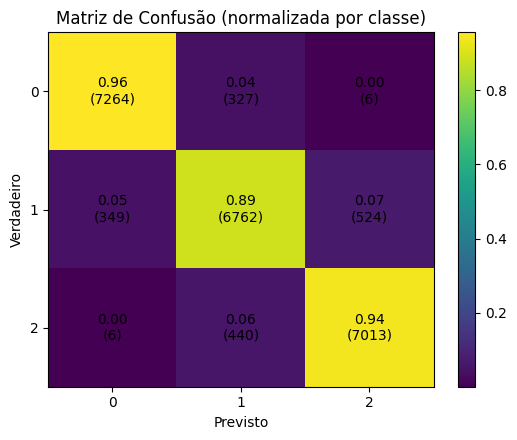

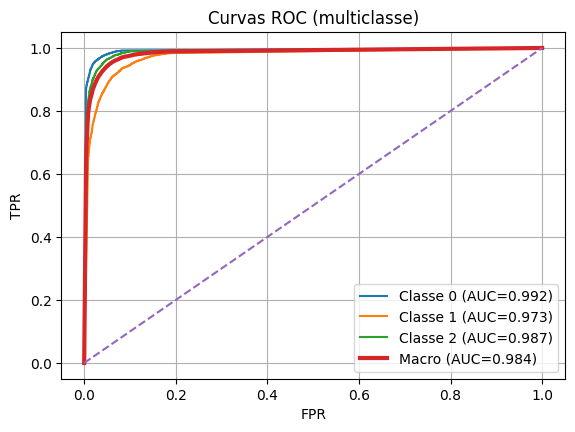

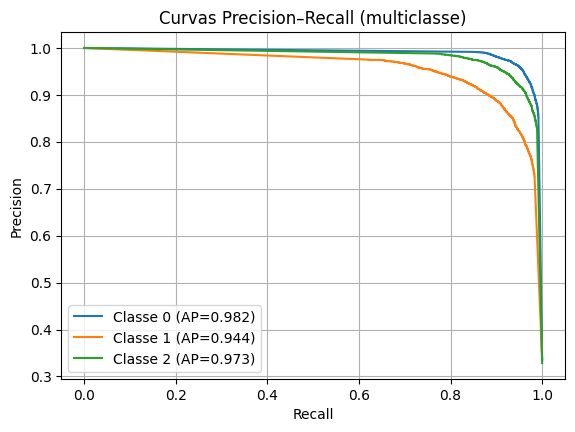

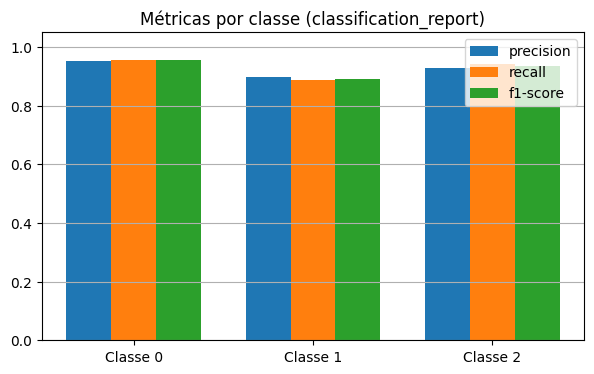

In [30]:
#Graficos dos resultados obtidos:

# 0) Probabilidades para ROC/PR
if hasattr(knn, "predict_proba"):
    proba = knn.predict_proba(X_test)
else:
    # fallback raro (KNN tem proba): usa decision_function -> normaliza
    scores = knn.decision_function(X_test)
    proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

classes = np.unique(y_test)  # ex.: [0,1,2]
n_classes = len(classes)
Y_te_bin = label_binarize(y_test, classes=classes)

# 1) Matriz de confusão normalizada por linha (recall por classe)
cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5.5,4.5))
plt.imshow(cm_norm, interpolation='nearest', aspect='auto')
plt.title('Matriz de Confusão (normalizada por classe)')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# anotações
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}\n({cm[i,j]})",
                 ha="center", va="center")
plt.tight_layout()
plt.show()

# 2) ROC por classe + macro-average
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(classes):
    fpr[c], tpr[c], _ = roc_curve(Y_te_bin[:, i], proba[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6.5,4.5))
for c in classes:
    plt.plot(fpr[c], tpr[c], label=f"Classe {c} (AUC={roc_auc[c]:.3f})")
plt.plot(all_fpr, mean_tpr, linewidth=3, label=f"Macro (AUC={macro_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC (multiclasse)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 3) Precision–Recall por classe + AP
plt.figure(figsize=(6.5,4.5))
for i, c in enumerate(classes):
    prec, rec, _ = precision_recall_curve(Y_te_bin[:, i], proba[:, i])
    ap = average_precision_score(Y_te_bin[:, i], proba[:, i])
    plt.plot(rec, prec, label=f"Classe {c} (AP={ap:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision–Recall (multiclasse)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# 4) Barras com precision/recall/F1 por classe
report = classification_report(y_test, y_pred, output_dict=True)
metrics = ["precision","recall","f1-score"]
vals = np.array([[report[str(c)][m] for m in metrics] for c in classes])

x = np.arange(n_classes)
w = 0.25
plt.figure(figsize=(7,4))
for i, m in enumerate(metrics):
    plt.bar(x + i*w - w, vals[:, i], width=w, label=m)
plt.xticks(x, [f"Classe {c}" for c in classes])
plt.ylim(0,1.05)
plt.title('Métricas por classe (classification_report)')
plt.legend()
plt.grid(True, axis='y')
plt.show()

In [27]:
#Vamos testar outras configurações do KNN
#Alteraremos as configurações de numero de vizinhos
#Alteraremos o p=1 para distancia da manhattan e p=2 para distancias enclidianas

candidates = [
    dict(n_neighbors=3,  weights='uniform',  p=2),
    dict(n_neighbors=5,  weights='uniform',  p=2),
    dict(n_neighbors=7,  weights='uniform',  p=2),
    dict(n_neighbors=9,  weights='uniform',  p=2),
    dict(n_neighbors=5,  weights='distance', p=2),
    dict(n_neighbors=7,  weights='distance', p=2),
    dict(n_neighbors=5,  weights='distance', p=1),  # Manhattan
    dict(n_neighbors=7,  weights='distance', p=1),
]

best = None
for cfg in candidates:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(**cfg))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if (best is None) or (acc > best[0]):
        best = (acc, cfg, knn, y_pred)

print("Melhor acurácia:", best[0], "com", best[1])
print("Matriz de Confusão:\n", confusion_matrix(y_test, best[3]))
print(classification_report(y_test, best[3], digits=3))

Melhor acurácia: 0.9271958045039884 com {'n_neighbors': 7, 'weights': 'distance', 'p': 1}
Matriz de Confusão:
 [[7264  327    6]
 [ 349 6762  524]
 [   6  440 7013]]
              precision    recall  f1-score   support

           0      0.953     0.956     0.955      7597
           1      0.898     0.886     0.892      7635
           2      0.930     0.940     0.935      7459

    accuracy                          0.927     22691
   macro avg      0.927     0.927     0.927     22691
weighted avg      0.927     0.927     0.927     22691



Baseline  (k=5, p=2, uniform)  -> Acc=0.9233, F1_macro=0.9234
Melhor KNN(k=7, p=1, distance) -> Acc=0.9272, F1_macro=0.9272


/tmp/ipython-input-1810165494.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


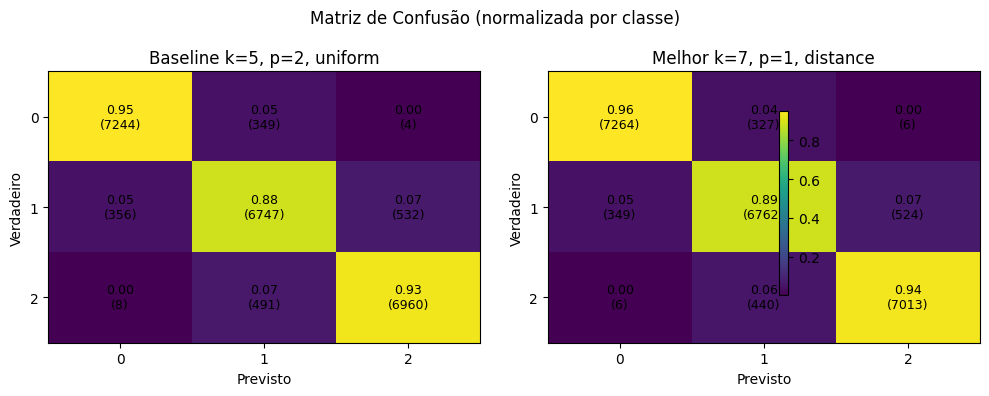

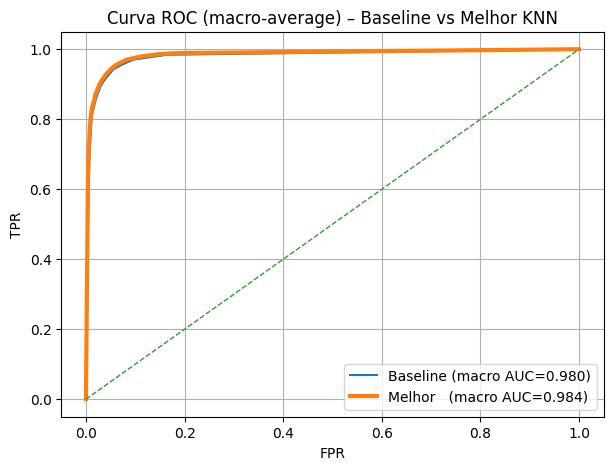

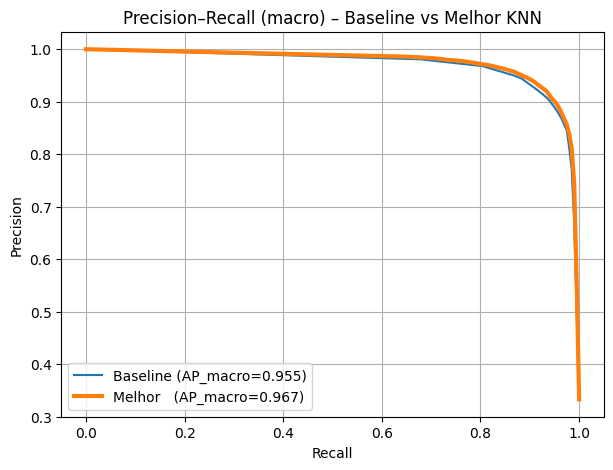

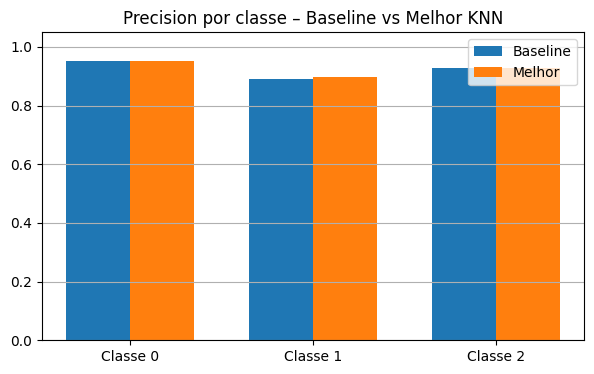

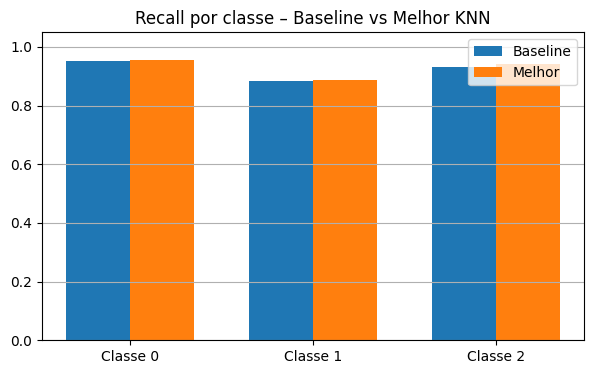

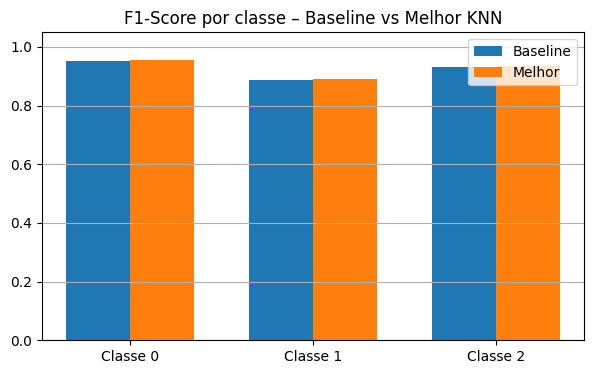

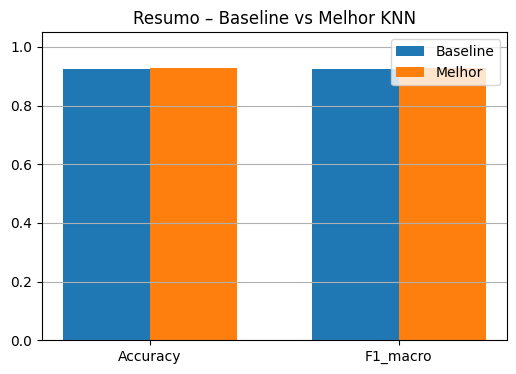

In [33]:
#Agora vamos traçar novamente os graficos com o modelo inicialmente proposto (k=5 e p=2 ) com o modelo de melhor acuracia (k=7 e p=1) para visualizar as diferenças

# --------------------------
# 1) (Re)constroi os dois modelos
# --------------------------
# Baseline: k=5, Euclidiana, pesos uniformes
knn_base = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2))
knn_base.fit(X_train, y_train)
y_pred_base = knn_base.predict(X_test)
proba_base  = knn_base.predict_proba(X_test)

# Melhor (do seu loop): usa o pipeline salvo em 'best[2]'
knn_best = best[2]
y_pred_best = best[3]
proba_best  = knn_best.predict_proba(X_test)

# Métricas agregadas
acc_base = accuracy_score(y_test, y_pred_base)
acc_best = accuracy_score(y_test, y_pred_best)
f1m_base = f1_score(y_test, y_pred_base, average='macro')
f1m_best = f1_score(y_test, y_pred_best, average='macro')

print(f"Baseline  (k=5, p=2, uniform)  -> Acc={acc_base:.4f}, F1_macro={f1m_base:.4f}")
print(f"Melhor KNN(k=7, p=1, distance) -> Acc={acc_best:.4f}, F1_macro={f1m_best:.4f}")

classes = np.unique(y_test)
n_classes = len(classes)
Y_te_bin = label_binarize(y_test, classes=classes)

# --------------------------
# 2) Matrizes de confusão (normalizadas) – lado a lado
# --------------------------
cm_base = confusion_matrix(y_test, y_pred_base, labels=classes)
cm_best = confusion_matrix(y_test, y_pred_best, labels=classes)
cm_base_n = cm_base / cm_base.sum(axis=1, keepdims=True)
cm_best_n = cm_best / cm_best.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
for j,(cmn,title) in enumerate([(cm_base_n,"Baseline k=5, p=2, uniform"),
                                (cm_best_n,"Melhor k=7, p=1, distance")]):
    ax[j].imshow(cmn, interpolation='nearest', aspect='auto')
    ax[j].set_title(title)
    ax[j].set_xlabel('Previsto'); ax[j].set_ylabel('Verdadeiro')
    ax[j].set_xticks(range(n_classes)); ax[j].set_xticklabels(classes)
    ax[j].set_yticks(range(n_classes)); ax[j].set_yticklabels(classes)
    for i in range(n_classes):
        for k in range(n_classes):
            ax[j].text(k, i, f"{cmn[i,k]:.2f}\n({[cm_base,cm_best][j][i,k]})",
                       ha="center", va="center", fontsize=9)
fig.suptitle("Matriz de Confusão (normalizada por classe)")
fig.colorbar(ax[0].images[0], ax=ax.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

# --------------------------
# 3) ROC por classe e Macro-ROC – 2 modelos juntos
# --------------------------
fpr_b, tpr_b, auc_b = {}, {}, {}
fpr_m, tpr_m, auc_m = {}, {}, {}

for i,c in enumerate(classes):
    fpr_b[c], tpr_b[c], _ = roc_curve(Y_te_bin[:, i], proba_base[:, i])
    fpr_m[c], tpr_m[c], _ = roc_curve(Y_te_bin[:, i], proba_best[:, i])
    auc_b[c] = auc(fpr_b[c], tpr_b[c])
    auc_m[c] = auc(fpr_m[c], tpr_m[c])

# Macro-average
def macro_curve(fpr_dict, tpr_dict):
    all_fpr = np.unique(np.concatenate([fpr_dict[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes:
        mean_tpr += np.interp(all_fpr, fpr_dict[c], tpr_dict[c])
    mean_tpr /= n_classes
    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

all_fpr_b, mean_tpr_b, macro_auc_b = macro_curve(fpr_b, tpr_b)
all_fpr_m, mean_tpr_m, macro_auc_m = macro_curve(fpr_m, tpr_m)

plt.figure(figsize=(7,5))
plt.plot(all_fpr_b, mean_tpr_b, label=f"Baseline (macro AUC={macro_auc_b:.3f})")
plt.plot(all_fpr_m, mean_tpr_m, label=f"Melhor   (macro AUC={macro_auc_m:.3f})", linewidth=3)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curva ROC (macro-average) – Baseline vs Melhor KNN")
plt.legend(); plt.grid(True)
plt.show()

# --------------------------
# 4) Precision–Recall macro – 2 modelos juntos
# --------------------------
def macro_pr(y_bin, proba):
    precs, recs, aps = [], [], []
    for i in range(n_classes):
        pr, rc, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
        ap = average_precision_score(y_bin[:, i], proba[:, i])
        precs.append(pr); recs.append(rc); aps.append(ap)
    # interpolar recalls comuns
    grid = np.linspace(0,1,200)
    prec_interp = []
    for pr, rc in zip(precs, recs):
        prec_interp.append(np.interp(grid, rc[::-1], pr[::-1]))
    prec_mean = np.mean(prec_interp, axis=0)
    ap_macro = np.mean(aps)
    return grid, prec_mean, ap_macro

grid_b, prec_b, ap_b = macro_pr(Y_te_bin, proba_base)
grid_m, prec_m, ap_m = macro_pr(Y_te_bin, proba_best)

plt.figure(figsize=(7,5))
plt.plot(grid_b, prec_b, label=f"Baseline (AP_macro={ap_b:.3f})")
plt.plot(grid_m, prec_m, label=f"Melhor   (AP_macro={ap_m:.3f})", linewidth=3)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (macro) – Baseline vs Melhor KNN")
plt.legend(); plt.grid(True)
plt.show()

# --------------------------
# 5) Barras: precision/recall/F1 por classe (2 modelos)
# --------------------------
rep_base = classification_report(y_test, y_pred_base, output_dict=True)
rep_best = classification_report(y_test, y_pred_best, output_dict=True)

metrics = ["precision","recall","f1-score"]
vals_base = np.array([[rep_base[str(c)][m] for m in metrics] for c in classes])
vals_best = np.array([[rep_best[str(c)][m] for m in metrics] for c in classes])

x = np.arange(n_classes)
w = 0.35
for j, m in enumerate(metrics):
    plt.figure(figsize=(7,4))
    plt.bar(x - w/2, vals_base[:, j], width=w, label=f"Baseline")
    plt.bar(x + w/2, vals_best[:, j], width=w, label=f"Melhor")
    plt.xticks(x, [f"Classe {c}" for c in classes])
    plt.ylim(0,1.05)
    plt.title(f"{m.title()} por classe – Baseline vs Melhor KNN")
    plt.legend(); plt.grid(True, axis='y')
    plt.show()

# --------------------------
# 6) Barras: Acurácia e F1_macro (2 modelos)
# --------------------------
plt.figure(figsize=(6,4))
labels = ["Accuracy", "F1_macro"]
base_vals = [acc_base, f1m_base]
best_vals = [acc_best, f1m_best]
x = np.arange(len(labels)); w = 0.35
plt.bar(x - w/2, base_vals, width=w, label="Baseline")
plt.bar(x + w/2, best_vals, width=w, label="Melhor")
plt.xticks(x, labels); plt.ylim(0,1.05)
plt.title("Resumo – Baseline vs Melhor KNN")
plt.legend(); plt.grid(True, axis='y')
plt.show()

In [34]:
#Salvar os graficos para colocarmos no Markdown para apresentação
# === SALVAR GRÁFICOS PARA O RELATÓRIO ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

# -----------------------------
# 0) Garantir "best" (melhor KNN) disponível
# -----------------------------
if 'best' not in globals():
    # pequena busca de hiperparâmetros
    candidates = [
        dict(n_neighbors=3,  weights='uniform',  p=2),
        dict(n_neighbors=5,  weights='uniform',  p=2),
        dict(n_neighbors=7,  weights='uniform',  p=2),
        dict(n_neighbors=9,  weights='uniform',  p=2),
        dict(n_neighbors=5,  weights='distance', p=2),
        dict(n_neighbors=7,  weights='distance', p=2),
        dict(n_neighbors=5,  weights='distance', p=1),  # Manhattan
        dict(n_neighbors=7,  weights='distance', p=1),
    ]
    best = None
    for cfg in candidates:
        m = make_pipeline(StandardScaler(), KNeighborsClassifier(**cfg))
        m.fit(X_train, y_train)
        y_tmp = m.predict(X_test)
        acc = accuracy_score(y_test, y_tmp)
        if (best is None) or (acc > best[0]):
            best = (acc, cfg, m, y_tmp)

# -----------------------------
# 1) Reconstruir modelos: baseline e melhor
# -----------------------------
# Baseline: k=5, Euclidiana, pesos uniformes
knn_base = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2))
knn_base.fit(X_train, y_train)
y_pred_base = knn_base.predict(X_test)
proba_base  = knn_base.predict_proba(X_test)

# Melhor (do grid)
knn_best = best[2]
y_pred_best = best[3]
proba_best  = knn_best.predict_proba(X_test)

# Métricas agregadas
acc_base = accuracy_score(y_test, y_pred_base)
acc_best = accuracy_score(y_test, y_pred_best)
f1m_base = f1_score(y_test, y_pred_base, average='macro')
f1m_best = f1_score(y_test, y_pred_best, average='macro')

print(f"Baseline  -> Acc={acc_base:.4f}, F1_macro={f1m_base:.4f}")
print(f"Melhor KNN-> Acc={acc_best:.4f}, F1_macro={f1m_best:.4f}  | params: {best[1]}")

classes = np.unique(y_test)
n_classes = len(classes)
Y_te_bin = label_binarize(y_test, classes=classes)

# -----------------------------
# 2) Matriz de confusão (normalizada) – salvar PNG
# -----------------------------
def plot_cm_and_save(cm, classes, title, filename):
    cmn = cm / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5.5,4.5))
    im = plt.imshow(cmn, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.xlabel('Previsto'); plt.ylabel('Verdadeiro')
    plt.xticks(range(len(classes)), classes)
    plt.yticks(range(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cmn[i,j]:.2f}\n({cm[i,j]})", ha="center", va="center", fontsize=9)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(filename, dpi=160, bbox_inches="tight")
    plt.close()
    print("Salvo:", filename)

cm_base = confusion_matrix(y_test, y_pred_base, labels=classes)
cm_best = confusion_matrix(y_test, y_pred_best, labels=classes)
plot_cm_and_save(cm_base, classes, "Matriz de Confusão – Baseline (k=5, p=2, uniform)", "baseline_cm.png")
plot_cm_and_save(cm_best, classes, "Matriz de Confusão – Melhor (k=7, p=1, distance)", "best_cm.png")

# -----------------------------
# 3) ROC macro e por classe – comparação e salvar PNG
# -----------------------------
def macro_curve(fpr_dict, tpr_dict, classes):
    all_fpr = np.unique(np.concatenate([fpr_dict[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes:
        mean_tpr += np.interp(all_fpr, fpr_dict[c], tpr_dict[c])
    mean_tpr /= len(classes)
    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

fpr_b, tpr_b, auc_b = {}, {}, {}
fpr_m, tpr_m, auc_m = {}, {}, {}
for i,c in enumerate(classes):
    fpr_b[c], tpr_b[c], _ = roc_curve(Y_te_bin[:, i], proba_base[:, i])
    fpr_m[c], tpr_m[c], _ = roc_curve(Y_te_bin[:, i], proba_best[:, i])
    auc_b[c] = auc(fpr_b[c], tpr_b[c])
    auc_m[c] = auc(fpr_m[c], tpr_m[c])

all_fpr_b, mean_tpr_b, macro_auc_b = macro_curve(fpr_b, tpr_b, classes)
all_fpr_m, mean_tpr_m, macro_auc_m = macro_curve(fpr_m, tpr_m, classes)

plt.figure(figsize=(7,5))
plt.plot(all_fpr_b, mean_tpr_b, label=f"Baseline (macro AUC={macro_auc_b:.3f})")
plt.plot(all_fpr_m, mean_tpr_m, label=f"Melhor   (macro AUC={macro_auc_m:.3f})", linewidth=3)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curva ROC (macro-average) – Baseline vs Melhor KNN")
plt.legend(); plt.grid(True)
plt.savefig("roc_comparison.png", dpi=160, bbox_inches="tight")
plt.close()
print("Salvo: roc_comparison.png")

# -----------------------------
# 4) Precision–Recall macro – comparação e salvar PNG
# -----------------------------
def macro_pr(y_bin, proba, classes, n_grid=200):
    precs, recs, aps = [], [], []
    for i in range(len(classes)):
        pr, rc, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
        ap = average_precision_score(y_bin[:, i], proba[:, i])
        precs.append(pr); recs.append(rc); aps.append(ap)
    grid = np.linspace(0,1,n_grid)
    prec_interp = []
    for pr, rc in zip(precs, recs):
        prec_interp.append(np.interp(grid, rc[::-1], pr[::-1]))
    prec_mean = np.mean(prec_interp, axis=0)
    ap_macro = np.mean(aps)
    return grid, prec_mean, ap_macro

grid_b, prec_b, ap_b = macro_pr(Y_te_bin, proba_base, classes)
grid_m, prec_m, ap_m = macro_pr(Y_te_bin, proba_best, classes)

plt.figure(figsize=(7,5))
plt.plot(grid_b, prec_b, label=f"Baseline (AP_macro={ap_b:.3f})")
plt.plot(grid_m, prec_m, label=f"Melhor   (AP_macro={ap_m:.3f})", linewidth=3)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (macro) – Baseline vs Melhor KNN")
plt.legend(); plt.grid(True)
plt.savefig("pr_comparison.png", dpi=160, bbox_inches="tight")
plt.close()
print("Salvo: pr_comparison.png")

# -----------------------------
# 5) Barras: precision/recall/F1 por classe – salvar PNG
# -----------------------------
rep_base = classification_report(y_test, y_pred_base, output_dict=True)
rep_best = classification_report(y_test, y_pred_best, output_dict=True)

metrics = ["precision","recall","f1-score"]
vals_base = np.array([[rep_base[str(c)][m] for m in metrics] for c in classes])
vals_best = np.array([[rep_best[str(c)][m] for m in metrics] for c in classes])

x = np.arange(len(classes))
w = 0.35
fig, axes = plt.subplots(1, 3, figsize=(13,4), sharey=True)
for j, m in enumerate(metrics):
    axes[j].bar(x - w/2, vals_base[:, j], width=w, label="Baseline")
    axes[j].bar(x + w/2, vals_best[:, j], width=w, label="Melhor")
    axes[j].set_xticks(x); axes[j].set_xticklabels([f"Classe {c}" for c in classes])
    axes[j].set_title(m.title()); axes[j].set_ylim(0, 1.05); axes[j].grid(True, axis='y')
axes[0].set_ylabel("Score")
axes[0].legend(loc="lower right")
fig.suptitle("Métricas por classe – Baseline vs Melhor KNN")
plt.tight_layout()
plt.savefig("bars_metrics.png", dpi=160, bbox_inches="tight")
plt.close()
print("Salvo: bars_metrics.png")

# -----------------------------
# 6) Barras: Accuracy e F1_macro – salvar PNG
# -----------------------------
plt.figure(figsize=(6,4))
labels = ["Accuracy", "F1_macro"]
base_vals = [acc_base, f1m_base]
best_vals = [acc_best, f1m_best]
x = np.arange(len(labels)); w = 0.35
plt.bar(x - w/2, base_vals, width=w, label="Baseline")
plt.bar(x + w/2, best_vals, width=w, label="Melhor")
plt.xticks(x, labels); plt.ylim(0,1.05)
plt.title("Resumo – Baseline vs Melhor KNN")
plt.legend(); plt.grid(True, axis='y')
plt.savefig("acc_f1.png", dpi=160, bbox_inches="tight")
plt.close()
print("Salvo: acc_f1.png")


Baseline  -> Acc=0.9233, F1_macro=0.9234
Melhor KNN-> Acc=0.9272, F1_macro=0.9272  | params: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}
Salvo: baseline_cm.png
Salvo: best_cm.png
Salvo: roc_comparison.png
Salvo: pr_comparison.png
Salvo: bars_metrics.png
Salvo: acc_f1.png
